# K-Means Clustering

## What is K-Means Clustering?
- Referred to as Lloyd's algorithm
- The goal of clustering is to identify significant and meaningful groups of data.
- Records in each group are similar to one another.
- K-Means divides the data into K clusters by minimising the sum of squared distances of each record to centroid (mean of assigned cluster)
- K-Means are based on heuristics and rely on finding clusters whose members are close to one another.
- It finds the assignment of records that minimizes within-cluster sum of squares across all the clusters

![kmeans_goal](images/kmeans_goal.png)

## How does K-Means Algorithm work?
- Start by placing centroids randomly (pick k instances at random and using their locations as centroids)
- Label the instances by assigning them to the closest centroid.
- Update the centroid and label the instances again until the centroids stop moving
- The algorithm is guaranteed to converge in a finite number of steps. But it may not be the optimum solution. This depends on the initial centroid initialization.

![kmeans_convergence](images/kmeans_convergence.png)

## Limitations of K-Means
- Lloyd's algorithm returns a local optimum, not necessarily a global optimum.
- This is due to the initialization of centroids. Different initialization of centroids may yield different clusterings. Some initialization of centroids can yield empty clusters (when a centroid is "blocked off")   

![initialization](images/initialization.png)

## Modifications to Lloyd's Algorithm (K-Means Variants)
### 1. K-Means++
- The difference is in the initialization of centroids. Instead of choosing random initialization points, K-Means++ uses a smarter centroid intialization technique.
- The goal is to spread out the centroids. 
- This leads to better performance in practice.
-  K-Means++ is non-deterministic as it picks the next centroids based on probabilities depending on the distances between the data points and the existing centroids.
- This is the default initialization that scikit learn implementats. In Scikit learn, instead of fitting the whole dataset, it uses batches of data to move the centroids.

![kmeans++](images/kmeans%2B%2B.png)

![kmeans++algo](images/kmeans%2B%2B_algo.png)

In [ ]:
def initialize_centroids(self, X):

    # Pick the first centroid randomly
    c1 = np.random.choice(X.shape[0], 1)

    # Add first centroids to the list of cluster centers
    self.cluster_centers_ = X[c1]

    # Calculate and add c2, c3, ..., ck (we assume that we always have more unique data points than k!)
    while len(self.cluster_centers_) < self.n_clusters:

        # c is a data point representing the next centroid
        c = None

        #########################################################################################
        ### Your code starts here ###############################################################

        # Compute distance of data points from the centroids
        dist_centroid_point = euclidean_distances(X, self.cluster_centers_)
        
        # Get the distance from the nearest centroid
        dist_nearest_centroid = dist_centroid_point.min(axis=1)
        
        # Probability of choosing next random point is proportional to distance squared. 
        # Since probability is between 0 and 1, we have to divide the squared distance by the sum of sqaured distance
        p = np.square(dist_nearest_centroid)/ np.sum(np.square(dist_nearest_centroid))
        
        # Get the index of the random datapoint chosen
        next_centroid_index = np.random.choice(X.shape[0], 1, p=p)[0]
        c = X[next_centroid_index]
        
        ### Your code ends here #################################################################
        #########################################################################################                

        # Add next centroid c to the array of already existing centroids
        self.cluster_centers_ = np.concatenate((self.cluster_centers_, [c]), axis=0)

### 2. K-Medoids
- A problem with K-Means and K-Means++ clustering is that the final centroids are not interpretable since the centroids are not actual points but the mean of the points present in the cluster.
- The centroids in K-Medoids are chosen from the data points. This result makes the centroid interpretable.
- It does not require the calculation of averages. Only notion of distance or similarity is needed.
- It is more robust to noise and outliers. 
- However, it has more expensive update step

### 3. X-Means
- An automatic method to choose K.
- Iteratively, run K-Means K=2 over each subcluster.
- Split subcluster if meaningful wrt a scoring function.
- Examples of scoring functions are Bayesian Information Criterion (BIC), Akaike Information Criterion (AIC), Minimum Description Length (MDL)

## Hard and Soft Clustering
- Hard Clustering - assign each instance to a single cluster
- Soft Clustering - assign each instance a score per cluster.
- The score can be the distance between the instance and the centroid. It can also be a similarity score, such as Gaussian Radial Basis Function
- If we have high-dimensional dataset and we transform the data this way, we will have k-dimensional dataset. This transformation can be very efficient nonlinear dimensionality reduction technique.

## How to evaluate a cluster?
### External Quality Measures
**1. Cluster Parity**   
**2. Homogeneity Score**   
**3. Completeness Score**  

### Internal Quality Measures
**1. Silhouette Coeffcient**
- A good clustering will have high inter-cluster distances and low intra-cluster distances. For each data point x, we define the following:  

![sil_coeff](images/sil_coeff.png)

- Values near 0 denote overlapping clusters


## Example

For the K-Means example, let us use ``Total_Consumptions`` and ``Total_Impressions``

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

In [13]:
def read_data():
    df = pd.read_csv('../pca/data/dataset_Facebook.csv', sep=";")

    df = (df
            .rename(columns={'Page total likes': 'Total_Page_Likes',
                            'Post Month': 'Month_Posted',
                            'Post Weekday': 'Weekday_Posted',
                            'Post Hour': 'Hour_Posted',
                            'Lifetime Post Total Reach': 'Total_Reach',
                            'Lifetime Post Total Impressions': 'Total_Impressions',
                            'Lifetime Engaged Users': 'Total_Users_Engaged',
                            'Lifetime Post Consumers': 'Total_Consumers',
                            'Lifetime Post Consumptions': 'Total_Consumptions',
                            'Lifetime Post Impressions by people who have liked your Page': 'Total_Impressions_Liked_Pages',
                            'Lifetime Post reach by people who like your Page': 'Total_Reach_Liked_Pages',
                            'Lifetime People who have liked your Page and engaged with your post': 'Total_Engaged_Liked_Pages',
                            'comment': 'Comment',
                            'like': 'Like',
                            'share': 'Share',
                            'Total Interactions': 'Total_Interactions'})
            .dropna(axis=0, how='any')
            .reset_index()
            .drop("index",axis=1)
            .loc[:,['Total_Consumptions', 'Total_Impressions']]
    )


    return df

In [14]:
df = read_data()

In [15]:
df.head()

,Total_Consumptions,Total_Impressions
0,159,5091
1,1674,19057
2,154,4373
3,1119,87991
4,580,13594


Since these two columns are of very different scale, we will have to standardise it to put them on the same scale

In [27]:
mean = np.array(np.mean(df, axis=0))
std = np.array(np.std(df, axis=0))

In [30]:
df_scaled = (df-mean)/std

In [38]:
X = np.array(df_scaled)

<AxesSubplot: xlabel='Total_Consumptions', ylabel='Total_Impressions'>

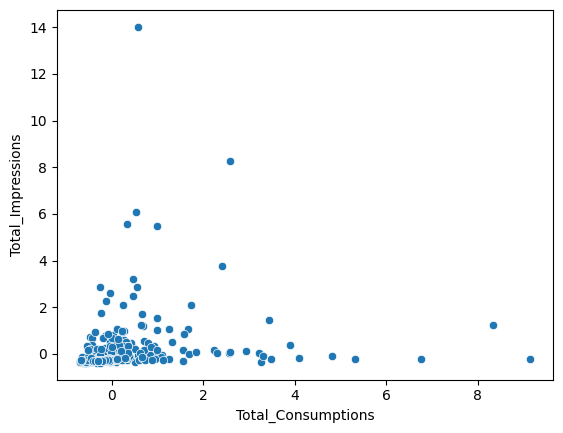

In [34]:
sns.scatterplot(data=df_scaled, x="Total_Consumptions", y="Total_Impressions")

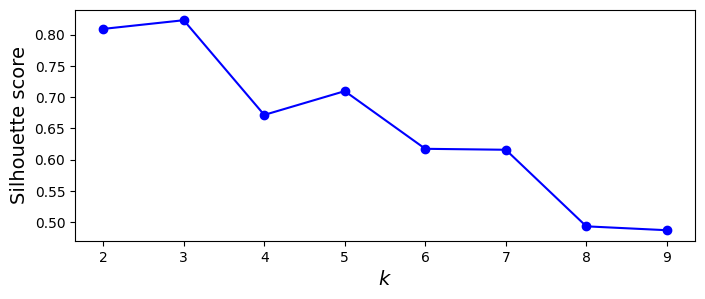

In [52]:
kmeans_per_k = [KMeans(init='k-means++', n_init='auto', n_clusters=k, random_state=42).fit(X) for k in range(1,10)]
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]
plt.figure(figsize=(8,3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

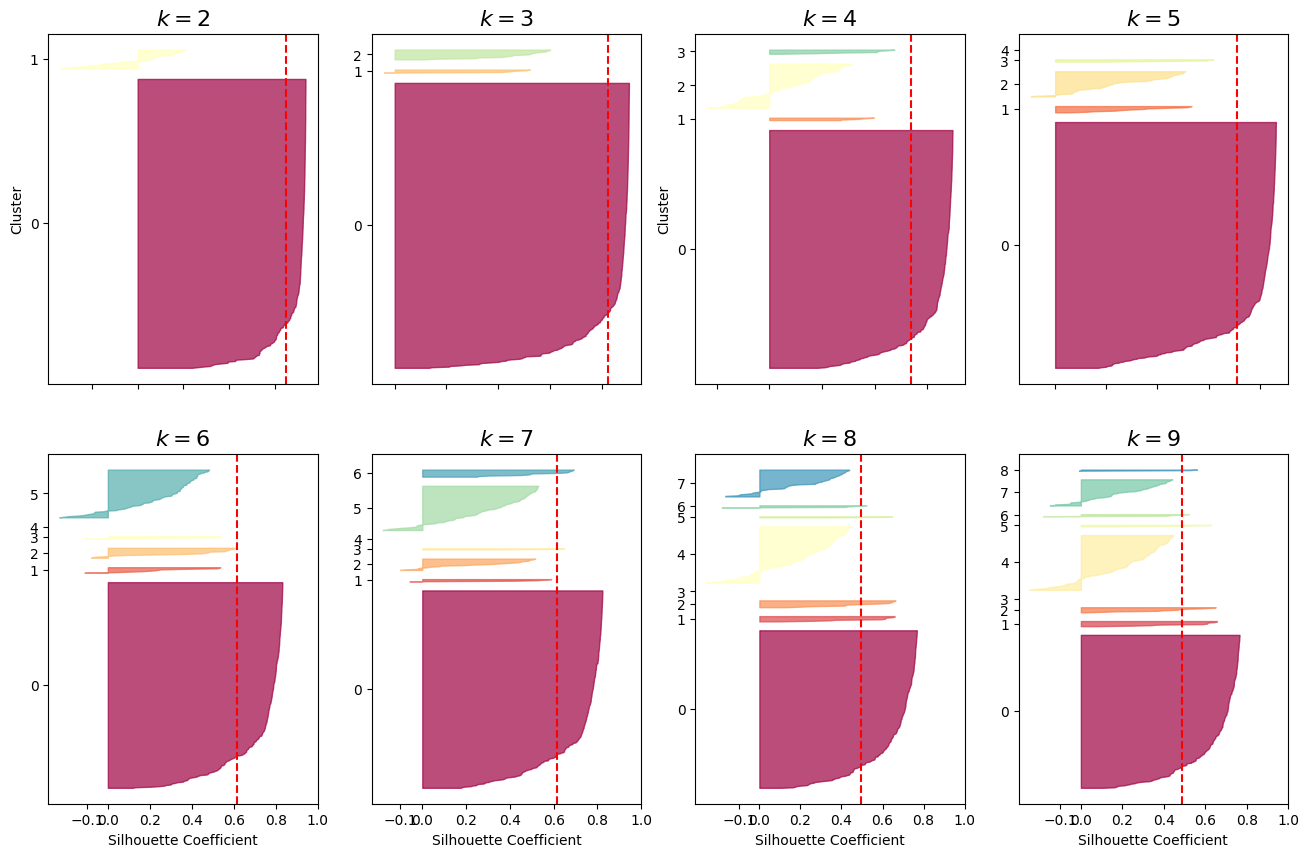

In [54]:
plt.figure(figsize=(16, 10))

for k in (2, 3, 4, 5, 6, 7, 8, 9):
    plt.subplot(2, 4, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (6,7,8,9):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

The silhouette coefficient score for k=3 is the best

In [58]:
k = 3
kmeans = KMeans(init='k-means++', n_init='auto', n_clusters=k, random_state=42)
pred_cluster = kmeans.fit_predict(X)

In [60]:
df_scaled = df_scaled.assign(Cluster = pred_cluster)

In [61]:
df_scaled.head()

,Total_Consumptions,Total_Impressions,Cluster
0,-0.631681,-0.321365,0
1,0.123691,-0.140141,0
2,-0.634174,-0.330682,0
3,-0.153029,0.754351,0
4,-0.421772,-0.211030,0


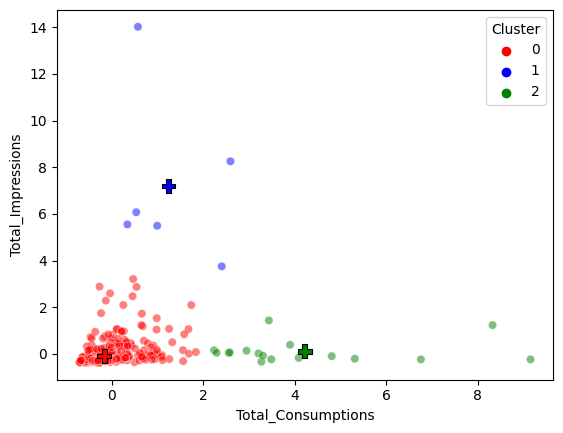

In [90]:
colors = ['red', 'blue', 'green']
ax = sns.scatterplot(data=df_scaled, x="Total_Consumptions", y="Total_Impressions", hue="Cluster", palette=colors, alpha=0.5)
ax = sns.scatterplot(data=kmeans, x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], hue=range(k), 
                     palette=colors, s=100,  ec='black', marker='P', legend=False)
plt.show()